# Determining Minimum Sampling Frequency for Temperature Data in Rimini

## Introduction
Temperature data is often downsampled, sometimes capturing only daily maximum and minimum values. However, being able to capture all the high-frequency variations in temperature is fundamental for accurate climate monitoring and forecasting. Recently, an interview raised the question of whether observed temperature oscillations might be due to aliasing, a phenomenon where high-frequency signals are misrepresented as lower frequencies due to insufficient sampling rates.

In this notebook, we will perform a detailed analysis on high-frequency temperature data from Rimini to determine the minimum sampling frequency required to accurately capture temperature variations without aliasing.

The data is available here:
- [August 10, 2017](https://www.wunderground.com/dashboard/pws/IRIMINIR5/table/2017-08-10/2017-08-10/daily)
- [June 19, 2024](https://www.wunderground.com/dashboard/pws/IRIMINIR5/table/2024-06-19/2024-06-19/daily)

## Theoretical Background
### Nyquist-Shannon Theorem
The Nyquist-Shannon sampling theorem states that a continuous signal can be completely represented in its samples and fully reconstructed if it has been sampled at a rate greater than twice its highest frequency component (the Nyquist rate). Mathematically,
$$ f_s > 2 \cdot f_{max} $$
where $ f_s $ is the sampling frequency and $ f_{max} $ is the maximum frequency of the signal.

### Aliasing
Aliasing occurs when a signal is undersampled, causing the sampled signals to be distorted. This effect makes high-frequency components appearing as lower frequencies in the sampled data, leading to incorrect interpretations of the data. Proper sampling, as dictated by the Nyquist-Shannon theorem, prevents aliasing.


In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


In [2]:
# Load all Excel files in the Data folder
file_paths = glob.glob('Data/*.xlsx')

In [3]:
# Function to load and clean data from each file
def load_and_clean_data(file_path):
    data = pd.read_excel(file_path, header=0, skiprows=[1])
    data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S')
    data['Temperature'] = data['Temperature'].str.replace(' °F', '').astype(float)
    return data

In [4]:
# Load and clean all data files
data_frames = {file_path: load_and_clean_data(file_path) for file_path in file_paths}


In [5]:
# Display the data for each file
for file_path, df in data_frames.items():
    print(f"Data from file: {file_path}")
    display(df.head())  # Display the first few rows of the data frame

Data from file: Data\10_08_2017.xlsx


,Time,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip. Rate.,Precip. Accum.,UV,Solar
0,1900-01-01 00:09:00,82.5,78.0 °F,85 %,NW,2.0 mph,5.0 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²
1,1900-01-01 00:24:00,84.1,75.0 °F,75 %,West,0.0 mph,4.0 mph,29.86 in,0.00 in,0.00 in,NaN,w/m²
2,1900-01-01 00:40:00,84.4,74.0 °F,70 %,SSE,5.0 mph,6.0 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²
3,1900-01-01 00:55:00,84.3,74.0 °F,70 %,SSE,0.0 mph,0.0 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²
4,1900-01-01 01:10:00,83.8,74.0 °F,73 %,NaN,0.0 mph,4.0 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²


Data from file: Data\19_06_2024.xlsx


,Time,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip. Rate.,Precip. Accum.,UV,Solar
0,1900-01-01 00:04:00,75.6,70.5 °F,84 %,West,0.3 mph,0.9 mph,30.02 in,0.00 in,0.00 in,0,0 w/m²
1,1900-01-01 00:09:00,75.4,70.4 °F,84 %,West,0.0 mph,0.3 mph,30.02 in,0.00 in,0.00 in,0,0 w/m²
2,1900-01-01 00:14:00,75.4,70.3 °F,84 %,West,0.2 mph,0.6 mph,30.02 in,0.00 in,0.00 in,0,0 w/m²
3,1900-01-01 00:19:00,75.2,70.2 °F,84 %,West,0.2 mph,1.0 mph,30.03 in,0.00 in,0.00 in,0,0 w/m²
4,1900-01-01 00:24:00,75.2,70.2 °F,84 %,West,0.0 mph,0.6 mph,30.03 in,0.00 in,0.00 in,0,0 w/m²


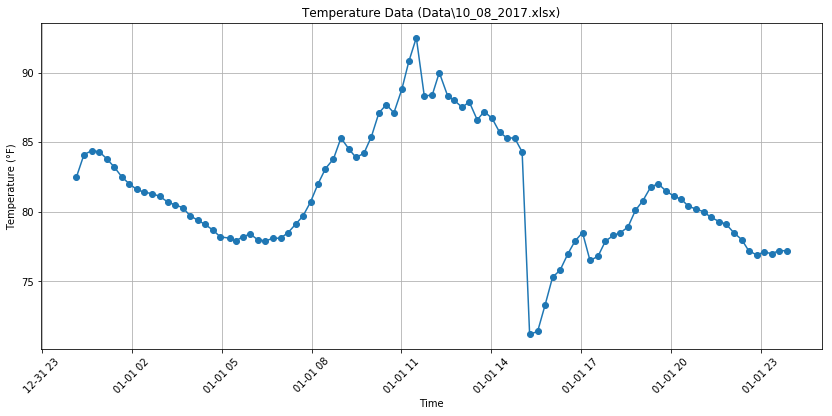

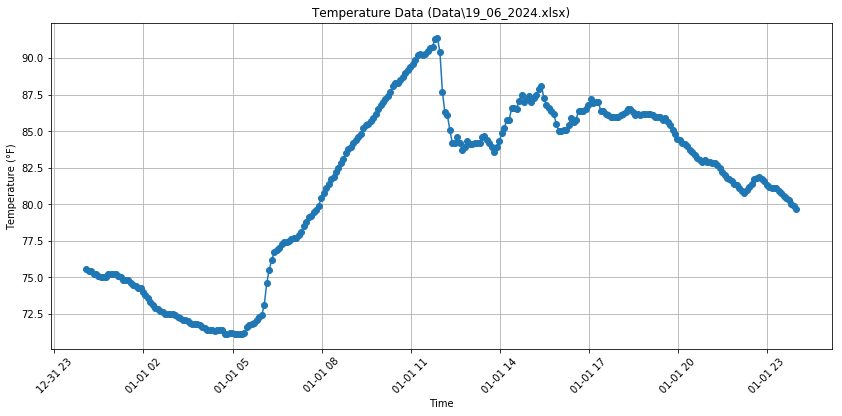

In [6]:
# Plot the temperature data for each file
for file_path, df in data_frames.items():
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'], df['Temperature'], marker='o')
    plt.title(f'Temperature Data ({file_path})')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°F)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


So far we have only plotted the data. Now, let's do a frequency analysis to reveal all the frequency components of the signal, and then let's find out where the majority of the information is.


In [7]:
# Function to perform FFT and plot results
def plot_fft(data, file_path):
    temp = data['Temperature'].dropna().values
    N = len(temp)
    T = data['Time'].diff().dt.total_seconds().dropna().values[0]  # Sampling interval in seconds
    
    fft_result = fft(temp)
    fft_magnitude = 2.0/N * np.abs(fft_result[:N//2])
    freqs = fftfreq(N, T)[:N//2]
    
    plt.figure(figsize=(14, 6))
    plt.plot(freqs, fft_magnitude)
    
    # Marking 95%, 97%, and 99% thresholds
    thresholds = [0.95, 0.97, 0.99]
    colors = ['r', 'g', 'b']
    for threshold, color in zip(thresholds, colors):
        cumulative_sum = np.cumsum(fft_magnitude)
        total_sum = cumulative_sum[-1]
        threshold_value = threshold * total_sum
        index = np.where(cumulative_sum >= threshold_value)[0][0]
        freq = freqs[index]
        plt.plot(freq, fft_magnitude[index], marker='o', markersize=8, color=color)
        plt.annotate(f'{int(threshold*100)}%', (freq, fft_magnitude[index]), textcoords="offset points", xytext=(0,10), ha='center', color=color)
    
    plt.title(f'FFT of Temperature Data ({file_path})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()
    
    return freqs, fft_magnitude, thresholds

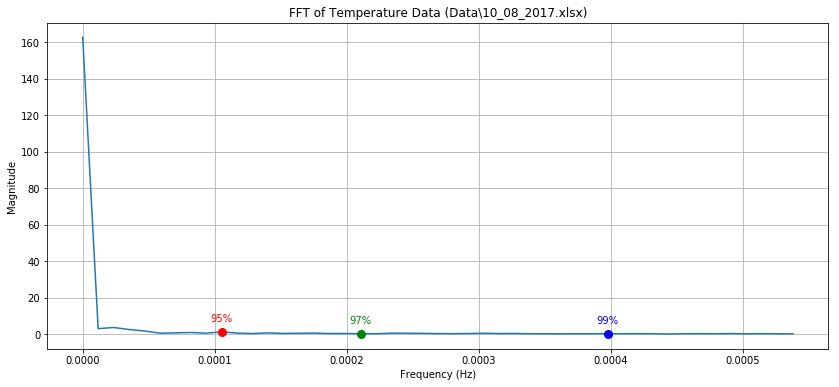

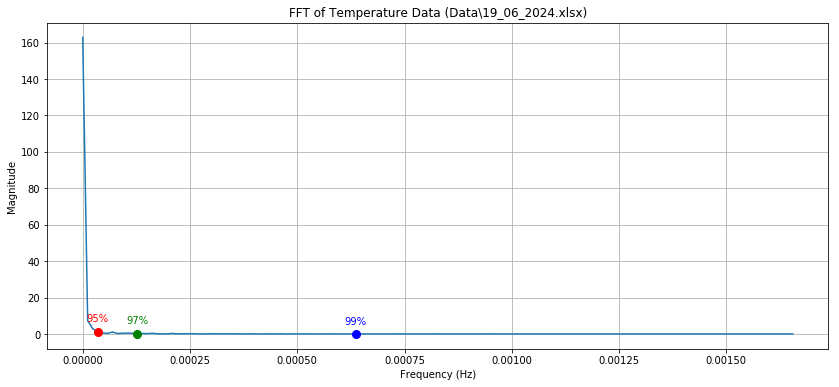

In [8]:
# Perform FFT and plot for each data file
fft_results = {file_path: plot_fft(df, file_path) for file_path, df in data_frames.items()}


In [9]:
# Determine 95%, 97%, and 99% Data Frequencies
def find_percent_frequencies(freqs, fft_magnitude, thresholds):
    percent_frequencies = {}
    cumulative_sum = np.cumsum(fft_magnitude)
    total_sum = cumulative_sum[-1]
    for threshold in thresholds:
        threshold_value = threshold * total_sum
        index = np.where(cumulative_sum >= threshold_value)[0][0]
        percent_frequencies[threshold] = freqs[index]
    return percent_frequencies

In [10]:
percent_freq_results = {file_path: find_percent_frequencies(freqs, fft_magnitude, [0.95, 0.97, 0.99]) for file_path, (freqs, fft_magnitude, thresholds) in fft_results.items()}

# Display the results in a table
percent_freq_table = pd.DataFrame(columns=['File', '95% Frequency (Hz)', '97% Frequency (Hz)', '99% Frequency (Hz)'])

for file_path, percent_frequencies in percent_freq_results.items():
    row = {
        'File': file_path,
        '95% Frequency (Hz)': percent_frequencies[0.95],
        '97% Frequency (Hz)': percent_frequencies[0.97],
        '99% Frequency (Hz)': percent_frequencies[0.99]
    }
    percent_freq_table = percent_freq_table.append(row, ignore_index=True)

print("Frequency capturing 95%, 97%, and 99% of data:")
display(percent_freq_table)

Frequency capturing 95%, 97%, and 99% of data:


,File,95% Frequency (Hz),97% Frequency (Hz),99% Frequency (Hz)
0,Data\10_08_2017.xlsx,0.000105,0.000211,0.000398
1,Data\19_06_2024.xlsx,0.000035,0.000127,0.000637


In [11]:
# Determine Minimum Sampling Frequency and Nyquist Rate
def minimum_sampling_frequency(frequency):
    return 2 * frequency  # Nyquist rate

In [12]:
min_sampling_freq_results = {file_path: {threshold: minimum_sampling_frequency(freq) for threshold, freq in percent_frequencies.items()} for file_path, percent_frequencies in percent_freq_results.items()}

# Convert the minimum sampling frequency to the number of measurements per minute
measurements_per_minute = {file_path: {threshold: min_sampling_freq * 60 for threshold, min_sampling_freq in min_sampling_freqs.items()} for file_path, min_sampling_freqs in min_sampling_freq_results.items()}


In [14]:
# Display the results in a table
sampling_freq_table = pd.DataFrame(columns=['File', '95% Sampling Rate (Hz)', '95% Measurements/Hour', '97% Sampling Rate (Hz)', '97% Measurements/Hour', '99% Sampling Rate (Hz)', '99% Measurements/Hour'])

for file_path, min_sampling_freqs in min_sampling_freq_results.items():
    row = {
        'File': file_path,
        '95% Sampling Rate (Hz)': min_sampling_freqs[0.95],
        '95% Measurements/Hour': measurements_per_minute[file_path][0.95] * 60,
        '97% Sampling Rate (Hz)': min_sampling_freqs[0.97],
        '97% Measurements/Hour': measurements_per_minute[file_path][0.97] * 60,
        '99% Sampling Rate (Hz)': min_sampling_freqs[0.99],
        '99% Measurements/Hour': measurements_per_minute[file_path][0.99] * 60
    }
    sampling_freq_table = sampling_freq_table.append(row, ignore_index=True)

print("\nMinimum sampling frequencies and measurements per hour:")
display(sampling_freq_table)



Minimum sampling frequencies and measurements per hour:


,File,95% Sampling Rate (Hz),95% Measurements/Hour,97% Sampling Rate (Hz),97% Measurements/Hour,99% Sampling Rate (Hz),99% Measurements/Hour
0,Data\10_08_2017.xlsx,0.000211,0.757895,0.000421,1.515789,0.000795,2.863158
1,Data\19_06_2024.xlsx,0.000069,0.250000,0.000255,0.916667,0.001273,4.583333


## Conclusion
The analysis reveals that the current sampling rates of 15 minutes (2017 data) and 5 minutes (2024 data) are more than sufficient to capture the significant temperature variations in Rimini. The minimum sampling frequencies required to avoid aliasing are much lower than the current sampling rates, ensuring accurate representation of temperature data without aliasing effects.
